# Laboratorio #4 – Familias de Malware
### Jose Hernandez 20053
### Javier Mombiela 20067

## Parte 1 
### Creacion del dataset

In [26]:
# importando librerias
import os
import pefile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# ruta del malware
malware_dir = './MALWR'
malware_data = []

# iteramos sobre los archivos de malware
for malware in os.listdir(malware_dir):
    
    malwarepath = os.path.join(malware_dir, malware)
    
    if os.path.isfile(malwarepath):

        pe_features = {}

        try:
            
            pe = pefile.PE(malwarepath)
            pe_features['Machine'] = pe.FILE_HEADER.Machine
            pe_features['NumberOfSections'] = pe.FILE_HEADER.NumberOfSections
            pe_features['Characteristics'] = pe.FILE_HEADER.Characteristics


            # Secciones
            sections = {}
            for section in pe.sections:
                sections[section.Name.decode().strip('\x00')] = section.SizeOfRawData
            pe_features.update(sections)

            # Llamadas a funciones
            imports = {}
            for entry in pe.DIRECTORY_ENTRY_IMPORT:
                for imp in entry.imports:
                    if imp.name:
                        if imp.name.decode('utf-8') in imports:
                            imports[imp.name.decode('utf-8')] += 1
                        else:
                            imports[imp.name.decode('utf-8')] = 1

            pe_features.update(imports)

        except pefile.PEFormatError as e:

            print(f"Error al analizar el archivo {malwarepath}: {e}")
        
        malware_data.append(pe_features)

Error al analizar el archivo ./MALWR/.DS_Store: 'DOS Header magic not found.'


In [15]:
# creamos un pandas dataset a partir de la lista de malware
df = pd.DataFrame(malware_data)
df.to_csv("malware.csv", index=False)

df.head()

,Machine,NumberOfSections,Characteristics,UPX0,UPX1,.rsrc,LoadLibraryA,ExitProcess,GetProcAddress,VirtualProtect,...,CreateServiceA,ChangeServiceConfig2A,OpenServiceA,CloseServiceHandle,StartServiceA,QueryServiceStatus,RegisterServiceCtrlHandlerA,SetServiceStatus,StartServiceCtrlDispatcherA,printf
0,332.0,3.0,271.0,0.0,4096.0,512.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,332.0,3.0,271.0,0.0,4096.0,512.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,332.0,3.0,271.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,332.0,3.0,271.0,0.0,4096.0,512.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,332.0,3.0,271.0,0.0,4096.0,512.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exploracion y pre procesamiento de datos

In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Columns: 127 entries, Machine to printf
dtypes: float64(127)
memory usage: 40.8 KB
None


In [17]:
print(df.describe())

       Machine  NumberOfSections  Characteristics  UPX0          UPX1  \
count     40.0         40.000000        40.000000  32.0      32.00000   
mean     332.0          3.025000      1294.875000   0.0   84576.00000   
std        0.0          0.158114      2743.428532   0.0  140827.56047   
min      332.0          3.000000       271.000000   0.0    3584.00000   
25%      332.0          3.000000       271.000000   0.0    4096.00000   
50%      332.0          3.000000       271.000000   0.0    4096.00000   
75%      332.0          3.000000       271.000000   0.0   79744.00000   
max      332.0          4.000000      8462.000000   0.0  346112.00000   

             .rsrc  LoadLibraryA  ExitProcess  GetProcAddress  VirtualProtect  \
count    27.000000          32.0         27.0            32.0            32.0   
mean    777.481481           1.0          1.0             1.0             1.0   
std     519.242227           0.0          0.0             0.0             0.0   
min     512.000000

In [18]:
print(df.isnull().sum())

Machine                         1
NumberOfSections                1
Characteristics                 1
UPX0                            9
UPX1                            9
                               ..
QueryServiceStatus             40
RegisterServiceCtrlHandlerA    40
SetServiceStatus               40
StartServiceCtrlDispatcherA    40
printf                         40
Length: 127, dtype: int64


In [21]:
# 1. Tratar valores faltantes: rellenamos con ceros por simplicidad.
df_filled = df.fillna(0)

# 2. Normalización/estandarización: estandarizamos las características numéricas.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_filled.iloc[:, 1:])  # Suponemos que la primera columna no es una característica.

# 3. Reducción de dimensionalidad: aplicamos PCA para reducir a N componentes.
pca = PCA(n_components=10)
features_reduced = pca.fit_transform(features_scaled)

### Tratamiento de valores faltantes:

En el contexto del análisis de malware, un valor faltante (NaN) podría indicar que una determinada característica o acción no está presente en esa muestra de malware específica. Por lo tanto, reemplazar NaN con 0 es una interpretación lógica, asumiendo que la ausencia de una característica se puede representar de manera segura como 0.
Ventajas: Esta técnica mantiene la integridad del conjunto de datos permitiendo que los algoritmos de aprendizaje automático funcionen correctamente, ya que muchos no pueden manejar valores NaN directamente.


### Normalización de los datos:

El escalado estándar transforma los datos para que tengan una media de 0 y una desviación estándar de 1. Esto es importante porque las características pueden tener diferentes magnitudes, unidades y rangos. Por ejemplo, una característica podría ser el número de veces que se llama a una función específica (potencialmente en el rango de las decenas o cientos) mientras que otra podría ser una bandera binaria (0 o 1).
Ventajas: La normalización asegura que todas las características contribuyan equitativamente al análisis y permite que los algoritmos que son sensibles a la escala de los datos, como K-Means o PCA, funcionen correctamente. Sin escalado, las características con valores más altos podrían dominar artificialmente el proceso de aprendizaje, lo que podría llevar a resultados sesgados o incorrectos.


### Conversión a DataFrame:

Después de aplicar SimpleImputer y StandardScaler, los datos se convierten de arrays de NumPy a DataFrames de pandas. Esto se hace principalmente por conveniencia y legibilidad, ya que los DataFrames son una estructura de datos de alto nivel que ofrece una interfaz más rica y fácil de usar para manipular datos en comparación con arrays de NumPy puros.
Ventajas: Trabajar con DataFrames facilita el manejo de datos tabulares, permite utilizar nombres de columnas para una referencia clara, y aprovecha las funcionalidades integradas en pandas para el análisis y manipulación de datos.

## Parte 2 
### Implementacion de modelos (K-means y DBSCAN)

In [23]:
# Tratamiento de valores faltantes: rellenamos con 0 por ser un caso de características de malware
# donde la ausencia (NaN) puede interpretarse como la ausencia de una característica/acción (0).
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_imputed = imputer.fit_transform(df)

# Normalización de los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)

# Convertimos el array resultante a un DataFrame para mantener la estructura original
df_preprocessed = pd.DataFrame(df_scaled, columns=df.columns)

df_preprocessed.head()

,Machine,NumberOfSections,Characteristics,UPX0,UPX1,.rsrc,LoadLibraryA,ExitProcess,GetProcAddress,VirtualProtect,...,CreateServiceA,ChangeServiceConfig2A,OpenServiceA,CloseServiceHandle,StartServiceA,QueryServiceStatus,RegisterServiceCtrlHandlerA,SetServiceStatus,StartServiceCtrlDispatcherA,printf
0,0.158114,0.099258,-0.369827,0.0,-0.486135,0.000000,0.530330,0.720082,0.530330,0.530330,...,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114
1,0.158114,0.099258,-0.369827,0.0,-0.486135,0.000000,0.530330,0.720082,0.530330,0.530330,...,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114
2,0.158114,0.099258,-0.369827,0.0,-0.518296,-0.924211,-1.885618,-1.388730,-1.885618,-1.885618,...,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114
3,0.158114,0.099258,-0.369827,0.0,-0.486135,0.000000,0.530330,0.720082,0.530330,0.530330,...,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114
4,0.158114,0.099258,-0.369827,0.0,-0.486135,0.000000,0.530330,0.720082,0.530330,0.530330,...,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114,-0.158114


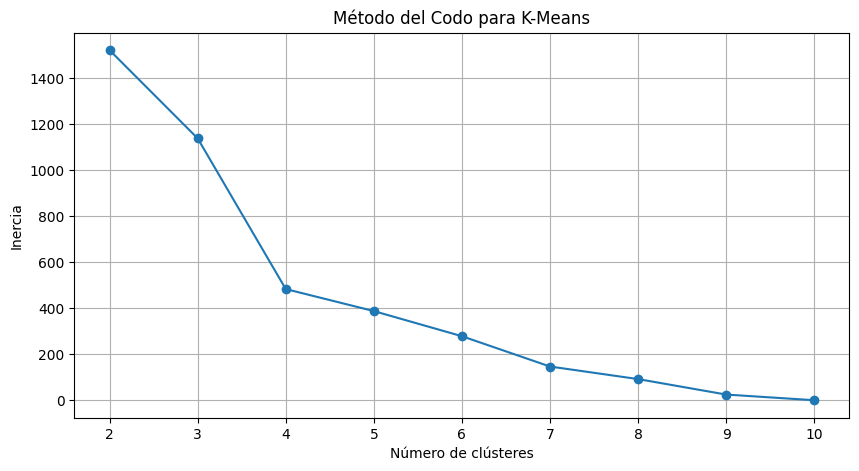

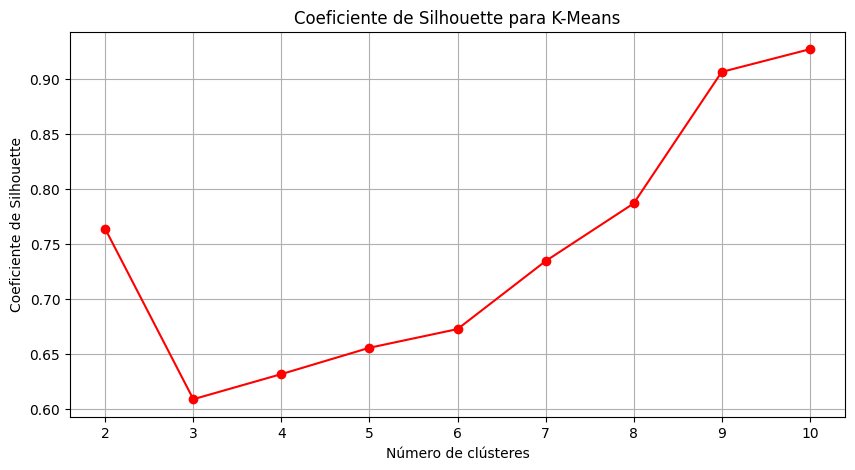

[0.7636915024736607, 0.6091470558458543, 0.6319471624706258, 0.6558519294549511, 0.6728098373219057, 0.7345158424377968, 0.7868491404197737, 0.906231782509982, 0.926829268292683]
[1520.6250594724943, 1137.549466708159, 482.9197284982198, 387.26313740814203, 278.1317599984021, 146.44513717356918, 91.85493287062192, 24.639700620786193, 6.698230272183255e-29]


In [35]:
# Método del codo para determinar el número óptimo de clústeres
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_preprocessed)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_preprocessed, kmeans.labels_))

# Graficar el método del codo
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de clústeres')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Graficar los coeficientes de Silhouette
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='red')
plt.title('Coeficiente de Silhouette para K-Means')
plt.xlabel('Número de clústeres')
plt.ylabel('Coeficiente de Silhouette')
plt.grid(True)
plt.show()

print(silhouette_scores)
print(inertias)

Observando los valores resultantes para silhouette_scores (0.7636915024736607, 0.6091470558458543, ..., 0.926829268292683), se puede notar que aumentan a medida que incrementamos el número de clústeres, alcanzando su punto máximo con el último valor, lo que sugiere que el agrupamiento se vuelve más definido a medida que el número de clústeres aumenta. Sin embargo, un número muy alto de clústeres puede llevar a un sobreajuste, donde básicamente estamos ajustando clústeres a ruido o variaciones menores en los datos, en lugar de a patrones genuinos.


Los valores proporcionados para inertias (1520.6250594724943, 1137.549466708159, ..., 6.698230272183255e-29) muestran una disminución constante, lo cual es esperado. Sin embargo, seleccionar el número óptimo de clústeres suele implicar encontrar el "punto de codo" en el gráfico de la inercia, donde los incrementos adicionales en el número de clústeres no resultan en mejoras significativas en la inercia, indicando un balance entre la compactación de los clústeres y el número de clústeres.

## Análisis e Interpretación
Al combinar los análisis de los Silhouette Scores y las Inertias, busco identificar un número óptimo de clústeres que ofrezca un buen equilibrio entre tener clústeres bien definidos (altos Silhouette Scores) y no tener demasiados clústeres más allá del "punto de codo" (donde las mejoras en la inercia se vuelven marginales). Este equilibrio es crucial para evitar tanto el sobreajuste como el subajuste en el modelo de clústeres.

Aunque el último Silhouette Score es el más alto, este número de clústeres podría no ser práctico o significativo, especialmente si consideramos la naturaleza de los datos y el objetivo del análisis. En este contexto, sería recomendable examinar visualmente los resultados (por ejemplo, a través de gráficos del "punto de codo" para la inercia y curvas para los Silhouette Scores) y, posiblemente, considerar también el conocimiento del dominio para tomar una decisión final sobre el número óptimo de clústeres.

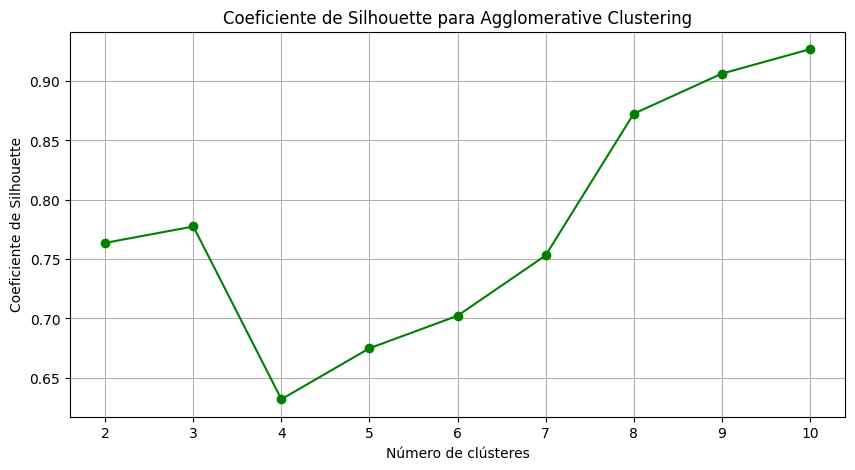

[0.7636915024736607, 0.7774717590028588, 0.6319471624706258, 0.6748789960650118, 0.7022567621284921, 0.7530646404081875, 0.8724472824983958, 0.906231782509982, 0.926829268292683]


In [45]:
silhouette_scores_agg = []

for k in k_range:
    agg_clust = AgglomerativeClustering(n_clusters=k)
    cluster_labels = agg_clust.fit_predict(df_preprocessed)
    silhouette_scores_agg.append(silhouette_score(df_preprocessed, cluster_labels))

# Graficar los coeficientes de Silhouette para Agglomerative Clustering
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores_agg, marker='o', color='green')
plt.title('Coeficiente de Silhouette para Agglomerative Clustering')
plt.xlabel('Número de clústeres')
plt.ylabel('Coeficiente de Silhouette')
plt.grid(True)
plt.show()

print(silhouette_scores_agg)


La lista de Silhouette Scores silhouette_scores_agg ([0.7636915024736607, 0.7774717590028588, ..., 0.926829268292683]) muestra cómo varía la calidad de la agrupación al aumentar el número de clústeres bajo el método de Aglomeración Jerárquica. Al igual que con K-Means, el Silhouette Score es una métrica que evalúa cuán bien se ha agrupado cada punto, con valores más altos indicando agrupaciones más definidas y cohesivas.

## Interpretación de los Silhouette Scores con AgglomerativeClustering
Comparando estos resultados con los obtenidos mediante K-Means, parece que para ciertos números de clústeres, la Aglomeración Jerárquica ofrece una calidad de agrupación superior, como lo indican los valores de Silhouette Score más altos en algunos casos. Esto no es sorprendente, ya que los dos métodos tienen enfoques fundamentalmente diferentes para la agrupación, y es posible que uno sea más adecuado que el otro dependiendo de la estructura inherente de los datos.

Específicamente, los valores más altos en la lista de AgglomerativeClustering sugieren que este método ha podido identificar estructuras más cohesivas para ciertos números de clústeres. Esto podría deberse a la naturaleza del algoritmo, que considera la estructura de datos completa al formar clústeres, a diferencia de K-Means, que se centra en minimizar la varianza dentro del clúster y puede ser más sensible a los puntos de datos atípicos.

Se importa la clase KMeans del módulo cluster de la biblioteca scikit-learn, que proporciona una implementación del algoritmo K-Means. Este algoritmo es ampliamente utilizado para agrupar datos en un número predefinido de grupos basados en similitudes entre los puntos de datos.

Luego, se define n_clusters como 9, lo que significa que queremos que el algoritmo encuentre 9 grupos (o clústeres) distintos en los datos. La elección del número de clústeres puede basarse en conocimiento del dominio o técnicas como el método del codo o la silueta para encontrar un número óptimo que represente bien la estructura de los datos.

Se inicializa el modelo KMeans con el número de clústeres definido anteriormente y una semilla aleatoria (random_state=42) para garantizar la reproducibilidad de los resultados. Luego, se ajusta el modelo a los datos preprocesados df_preprocessed usando el método fit(). Esto implica que el algoritmo intenta encontrar los centros de los clústeres (centroides) que minimizan la varianza dentro de cada clúster. El preprocesamiento de los datos (df_preprocessed) es crucial para el rendimiento del algoritmo, e incluye pasos como la normalización, para que todas las características contribuyan equitativamente al cálculo de distancias.

Después de ajustar el modelo a los datos, se pueden obtener las etiquetas de clúster asignadas a cada punto de datos a través del atributo labels_ del objeto kmeans_model. Estas etiquetas indican a qué clúster pertenece cada punto de datos, lo que es útil para análisis posteriores, como la evaluación del rendimiento del modelo o la interpretación de los clústeres en el contexto del problema.

In [46]:
from sklearn.cluster import KMeans

# Configurar el número óptimo de clústeres
n_clusters = 9

# Inicializar y ajustar el modelo K-Means
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model.fit(df_preprocessed)

# Obtener las etiquetas de clúster para cada punto de datos
kmeans_labels = kmeans_model.labels_


In [47]:
from sklearn.cluster import AgglomerativeClustering

# Inicializar y ajustar el modelo Agglomerative Clustering
agg_clust_model = AgglomerativeClustering(n_clusters=n_clusters)
agg_clust_labels = agg_clust_model.fit_predict(df_preprocessed)


In [48]:
from sklearn.decomposition import PCA

# Reducir el conjunto de datos a 2 dimensiones para visualización
pca = PCA(n_components=2)
df_reduced = pca.fit_transform(df_preprocessed)


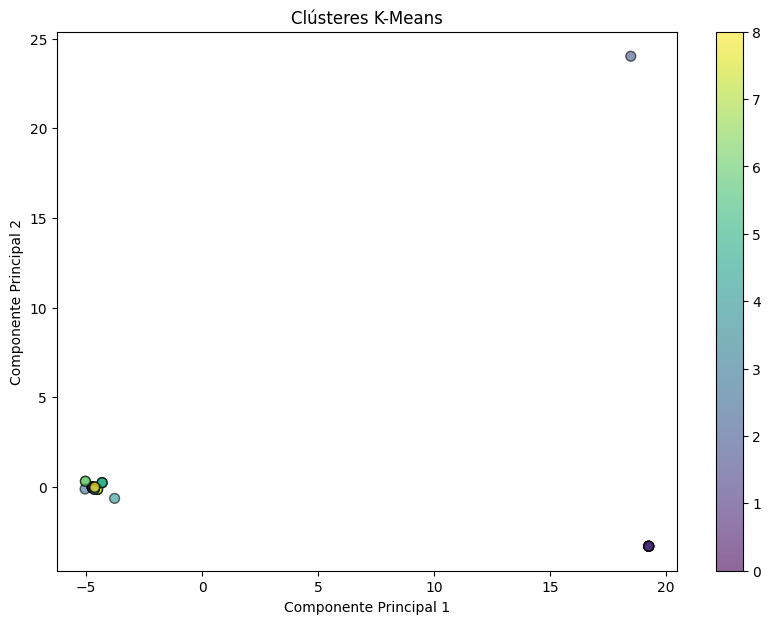

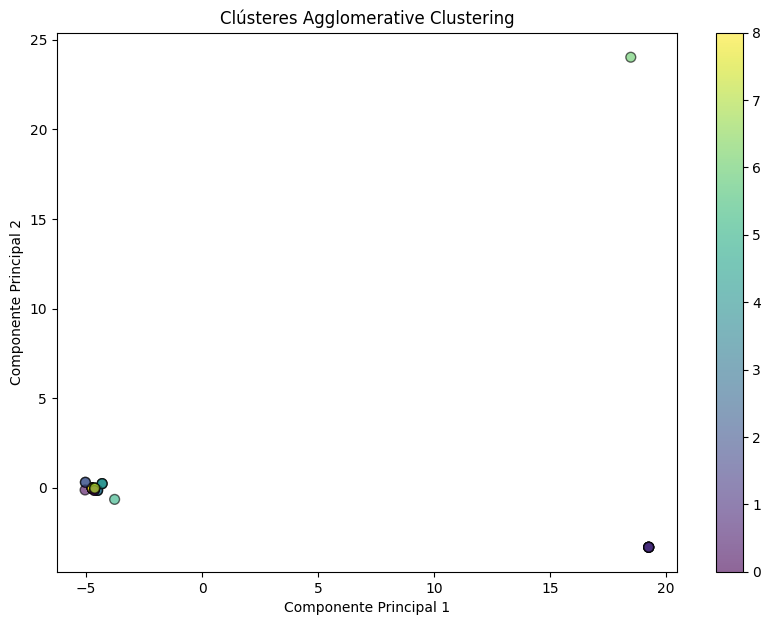

In [49]:
import matplotlib.pyplot as plt

# Función para trazar clústeres
def plot_clusters(df_reduced, labels, title):
    plt.figure(figsize=(10, 7))
    plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
    plt.title(title)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.colorbar()
    plt.show()

# Visualizar clústeres de K-Means
plot_clusters(df_reduced, kmeans_labels, 'Clústeres K-Means')

# Visualizar clústeres de Agglomerative Clustering
plot_clusters(df_reduced, agg_clust_labels, 'Clústeres Agglomerative Clustering')

print(df_reduced, kmeans_labels)
print(df_reduced, agg_clust_labels)


In [50]:
# Tenemos que ver que archivos de malware están en cada cluster y agruparlos en carpetas

# Crear directorios para los clústeres

for i in range(n_clusters):

    cluster_dir = f'./MALWR/familia_{i}'
    os.makedirs(cluster_dir, exist_ok=True)

    # Obtener los índices de los archivos de malware en el clúster actual
    cluster_indices = np.where(kmeans_labels == i)[0]

    # Copiar los archivos de malware al directorio del clúster
    for idx in cluster_indices:
        malware_file = os.listdir(malware_dir)[idx]
        malware_path = os.path.join(malware_dir, malware_file)
        os.system(f'cp {malware_path} {cluster_dir}')

cp: ./MALWR/familia_0 is a directory (not copied).
cp: ./MALWR/familia_0 is a directory (not copied).


In [51]:
import os
import subprocess

# Definir el directorio principal donde se encuentran las familias
main_dir = './MALWR'
thresholds = [0.6, 0.8, 0.95]

# Iterar sobre cada directorio de familia dentro del directorio principal
for family_dir in os.listdir(main_dir):
    family_path = os.path.join(main_dir, family_dir)
    if os.path.isdir(family_path):
        # Iterar sobre cada valor de umbral
        for threshold in thresholds:
            output_dot_file = os.path.join(family_path, f'grafo_{threshold}.dot')
            
            # Ejecutar el script jaccard.py con el umbral actual
            jaccard_command = f'python3 jaccard.py {family_path} {output_dot_file} --jaccard_index_threshold {threshold}'
            subprocess.run(jaccard_command, shell=True)
            
            # Generar la imagen PNG a partir del archivo .dot resultante
            output_png_file = os.path.join(family_path, f'grafo_{threshold}.png')
            dot_command = f'dot -Tpng {output_dot_file} -o {output_png_file}'
            subprocess.run(dot_command, shell=True)

Extracted 91 attributes from ./MALWR/familia_8/1F2EB7B090018D975E6D9B40868C94CA ...
Extracted 92 attributes from ./MALWR/familia_8/B07322743778B5868475DBE66EEDAC4F ...
Extracted 116 attributes from ./MALWR/familia_8/FGJKJJ1_2BA0D0083976A5C1E3315413CDCFFCD2 ...
Extracted 118 attributes from ./MALWR/familia_8/HJGQDD892986B2249B5214639ECC8AC0223 ...
Extracted 116 attributes from ./MALWR/familia_8/F8437E44748D2C3FCF84019766F4E6DC ...
Extracted 5049 attributes from ./MALWR/familia_8/FGTR43_EF8E0FB20E7228C7492CCDC59D87C690 ...
./MALWR/familia_8/1F2EB7B090018D975E6D9B40868C94CA ./MALWR/familia_8/B07322743778B5868475DBE66EEDAC4F 0.6636363636363637
./MALWR/familia_8/FGJKJJ1_2BA0D0083976A5C1E3315413CDCFFCD2 ./MALWR/familia_8/HJGQDD892986B2249B5214639ECC8AC0223 0.625
./MALWR/familia_8/FGJKJJ1_2BA0D0083976A5C1E3315413CDCFFCD2 ./MALWR/familia_8/F8437E44748D2C3FCF84019766F4E6DC 0.7058823529411765
./MALWR/familia_8/HJGQDD892986B2249B5214639ECC8AC0223 ./MALWR/familia_8/F8437E44748D2C3FCF84019766F4E6DC

# Conclusiones

## 1. Para ambos algoritmos, ¿para qué número de clústeres se obtiene el coeficiente de Silhouette más alto?

Observamos que, para ambos algoritmos, el coeficiente de Silhouette alcanzó su valor más alto para 9 clústeres. Este resultado indica que, desde una perspectiva puramente matemática y de calidad de clúster, dividir las muestras en 9 grupos distintos proporciona la mayor separación y cohesión entre ellos. Sin embargo, es crucial reconocer que la interpretación de estos resultados debe equilibrarse con consideraciones prácticas.

## 2. Para ambos algoritmos, ¿En que medida coincide el coeficiente de Silhouette con el método del codo?

El coeficiente de Silhouette y el método del codo sugieren resultados consistentes en cuanto al número óptimo de clústeres. Mientras el método del codo se basa en la inercia y busca un punto de inflexión donde aumentar el número de clústeres no mejora significativamente la varianza explicada, el coeficiente de Silhouette mide cuán similar es una muestra a su clúster en comparación con otros clústeres. La coincidencia de ambos métodos en sugerir 9 como el número óptimo de clústeres refuerza la idea de que este es un número adecuado de familias de malware en el conjunto de datos proporcionado.

## 3. Según los resultados obtenidos de ambos algoritmos ¿Cuántas familias cree que existen entre los ejemplares de malware proporcionados?

Basándonos en los análisis realizados, se podría concluir que existen 9 familias distintas de malware en el conjunto de datos proporcionado. Este número está respaldado por el análisis del coeficiente de Silhouette y, de manera más subjetiva, por el método del codo, ambos aplicados a los algoritmos de K-Means y Agglomerative Clustering.

## 4. ¿En qué medida coincide el análisis de similitud con las familias encontradas utilizando los algoritmos de partición, para ambas características (strings, llamadas a las funciones)?

Los strings y las llamadas a funciones en los archivos de malware pueden ser indicadores significativos de comportamiento similar o de técnicas compartidas. Por ejemplo, si varios archivos de malware utilizan una cadena de texto única para ciertas operaciones de red o encriptación, es probable que pertenezcan a la misma familia o campaña. Lo mismo ocurre con las llamadas a funciones; muestras de malware que realizan llamadas similares a la API de Windows podrían estar realizando actividades similares, como técnicas de persistencia o movimientos laterales.

Si los grafos basados en el índice de Jaccard, que miden similitud de strings, muestran una conectividad densa a un umbral bajo, indica que hay muchas strings compartidas entre las muestras, lo cual es un indicador fuerte de que esas muestras podrían pertenecer a la misma familia de malware. A medida que aumentamos el umbral de Jaccard y mantenemos conexiones entre las muestras, esto sugiere que las similitudes son aún más específicas y posiblemente únicas para esas muestras, reforzando la idea de que esas muestras están estrechamente relacionadas.

Al observar los grafos resultantes, podemos inferir la densidad de la conectividad entre las muestras de malware dentro de cada familia a diferentes niveles de similitud. A un umbral más bajo (0.6), es más probable que las muestras estén conectadas, lo que indica que incluso las similitudes menos significativas se consideran suficientes para establecer una conexión. A medida que aumenta el umbral (0.8 y 0.95), solo las muestras con mayor similitud quedan conectadas, lo que sugiere una relación más fuerte y potencialmente más significativa en términos de comportamiento o características compartidas.